In [20]:
import os
import pickle 
import joblib
import pandas as pd
import numpy as np
import random
import itertools
from datetime import datetime, timedelta
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

import sys
sys.path.append('/data/Hydra_Work/Competition_Functions') 
from Processing_Functions import process_forecast_date, process_seasonal_forecasts
from Data_Transforming import read_nested_csvs, generate_daily_flow, use_USGS_flow_data, USGS_to_daily_df_yearly
from Full_LSTM_ML_Functions import SumPinballLoss


sys.path.append('/data/Hydra_Work/Pipeline_Functions')
from Folder_Work import filter_rows_by_year, csv_dictionary, add_day_of_year_column


from datetime import datetime
import torch
import torch.nn as nn


In [2]:
basins = ['libby_reservoir_inflow',  'owyhee_r_bl_owyhee_dam',  'san_joaquin_river_millerton_reservoir',  'taylor_park_reservoir_inflow',
 'boise_r_nr_boise', 'green_r_bl_howard_a_hanson_dam', 'weber_r_nr_oakley', 'detroit_lake_inflow', 'virgin_r_at_virtin', 'dillon_reservoir_inflow',
 'pueblo_reservoir_inflow', 'hungry_horse_reservoir_inflow', 'stehekin_r_at_stehekin', 'pecos_r_nr_pecos', 'snake_r_nr_heise', 'yampa_r_nr_maybell',
 'colville_r_at_kettle_falls', 'missouri_r_at_toston', 'merced_river_yosemite_at_pohono_bridge', 'animas_r_at_durango','fontenelle_reservoir_inflow', 'boysen_reservoir_inflow']

selected_years = range(2000,2024,2)


base_dir = "/data/Hydra_Work/Scaled_Data"

# Define dictionaries and DataFrames
dictionaries = ['era5', 'seasonal_forecasts', 'daily_flow', 'climatological_flows']

dataframes = ['climate_indices', 'static_variables']

# Function to load dictionaries
def load_dictionaries(base_dir, names):
    loaded_dicts = {}
    for name in names:
        file_path = os.path.join(base_dir, f"{name}.pkl")
        with open(file_path, 'rb') as file:
            locals()[name] = pickle.load(file)
    return locals()

# Function to load DataFrames
def load_dataframes(base_dir, names):
    loaded_dfs = {}
    for name in names:
        file_path = os.path.join(base_dir, f"{name}.pkl")
        locals()[name] = pd.read_pickle(file_path)
    return locals()

saved_dicts = load_dictionaries(base_dir, dictionaries)
saved_dfs = load_dataframes(base_dir, dataframes)

for name in dictionaries:
    locals()[name] = saved_dicts[name]

for name in dataframes:
    locals()[name] = saved_dfs[name]

criterion = SumPinballLoss(quantiles = [0.1, 0.5, 0.9])

basin = 'animas_r_at_durango' 
All_Dates = daily_flow[basin].index[
    ((daily_flow[basin].index.month < 6) | ((daily_flow[basin].index.month == 6) & (daily_flow[basin].index.day < 24))) &
    ((daily_flow[basin].index.year % 2 == 0) | ((daily_flow[basin].index.month > 10) | ((daily_flow[basin].index.month == 10) & (daily_flow[basin].index.day >= 1))))
]
All_Dates = All_Dates[All_Dates.year > 1998]


# Validation Year
Val_Dates = All_Dates[All_Dates.year >= 2020]
All_Dates = All_Dates[All_Dates.year < 2020]

device = torch.device('cuda' if torch.cuda.
                is_available() else 'cpu')



In [3]:
# Load All the Models
General_LSTM_Model = torch.load('/data/Hydra_Work/Tuning/Week_Ahead_Models_V2/General_LSTM.pth')
Hydra_General_Head = torch.load('/data/Hydra_Work/Tuning/Week_Ahead_Models_V2/Hydra_Head_LSTM.pth')
Hydra_Body = torch.load('/data/Hydra_Work/Tuning/Week_Ahead_Models_V2/Hydra_Body_LSTM.pth')
Specific_Heads = {}
Specific_Models = {}
for basin in basins:
    Specific_Heads[f'{basin}'] = torch.load(f'/data/Hydra_Work/Tuning/Week_Ahead_Models_V2/Hydra_Heads/{basin}.path')
    Specific_Models[f'{basin}'] = torch.load(f'/data/Hydra_Work/Tuning/Week_Ahead_Models_V2/Specific_Week_Ahead_Models/{basin}_specific.pth') 
                                                

In [7]:
Hydra_General_Head

Google_LSTMModel(
  (hindcast): Hindcast_LSTM_Block(
    (lstm): LSTM(4, 32, batch_first=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (fc): Linear(in_features=32, out_features=3, bias=True)
  )
  (forecast): Forecast_LSTM_Block(
    (lstm): LSTM(4, 32, batch_first=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (fc): Linear(in_features=32, out_features=3, bias=True)
  )
)

# Evaluation Plots

In [8]:
import joblib
import sys
sys.path.append('/data/Hydra_Work/Performance_Evaluation') 
from Evaluation_Functions import test_weekly_performance, test_weekly_performance_hydra



In [9]:


feed_forcing = False
year = 2022
years = np.arange(2000,2024,2)
start_season_date = f'{year}-03-01' 
end_season_date = f'{year}-06-26'
basin = 'san_joaquin_river_millerton_reservoir'
daily_flow['san_joaquin_river_millerton_reservoir']


Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False)
_, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = False)
_, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = True)

Days = len(Basin_Head_Guesses)
Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)
Truth = np.array(Truth)


Outputs = [Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses, General_LSTM_Guesses, Specific_LSTM_Guesses]


In [31]:
def quantile_loss(predictions, true_values, quantiles = np.array([0.1,0.5,0.9])):
    """
    Compute the quantile loss for multiple quantiles.

    Parameters:
    predictions (numpy.ndarray): Array of shape (k, n) where k is the number of quantiles and n is the number of predictions.
    true_values (numpy.ndarray): Array of shape (n,) containing the true values.
    quantiles (numpy.ndarray): Array of shape (k,) containing the quantile values.

    Returns:
    numpy.ndarray: Array of shape (k,) containing the quantile loss for each quantile.
    """
    n,k = predictions.shape
    assert true_values.shape[0] == n
    assert len(quantiles) == k
    
    loss = np.zeros(k)

    for i in range(k):
        errors = true_values - predictions[:,i]
        loss[i] = np.mean(np.maximum(quantiles[i] * errors, (quantiles[i] - 1) * errors))
        
    overall_loss = np.sum(loss)
    
    return overall_loss


In [32]:
# Ideally I want a table with Model as one axis and Year as another, showing the performance of each model for each year and which one performed better
# Maybe a similar graph for each basin

for Output in Outputs:
    print(quantile_loss(Output, Truth.squeeze()))

0.818251347122549
0.20507158582881463
1.2307253040235944
0.49170582929809203
1.3643363925773755


In [12]:
np.shape(Truth.squeeze() - Output[:,0])

(112,)

In [4]:
def Matrix_Of_Scores(Hydra_Body, Hydra_General_Head, General_LSTM_Model, Specific_Models, basins, years, quantiles = 3):
    Scores = {}
    n = 0
    for year in years:
        
        for basin in basins:
            
            start_season_date = f'{year}-01-01' 
            end_season_date = f'{year}-06-26'

            Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False)
            _, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = False)
            _, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = True)

            Days = len(Basin_Head_Guesses)
            Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
            General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
            Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

            General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
            Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)
            Truth = np.array(Truth)

            model_names = ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "Specific_LSTM_Model"]
            Outputs = [Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses, General_LSTM_Guesses, Specific_LSTM_Guesses]
            
            for model_name, Output in zip(model_names, Outputs):
                Scores[f'{basin}_{year}_{model_name}'] = quantile_loss(Output, Truth)
            
        n = n+1
        print(f"{n} Years done")
    return Scores 
    
years = np.arange(2000,2024,2)





In [5]:
def Matrix_Of_CV_Scores(basins, years):
    Scores = {}
    n = 0
    for test_year in years:
        
        for basin in basins:
            
            General_LSTM_Model = torch.load(f'/data/Hydra_Work/Validation_Models/{test_year}/General_LSTM_Model/General_LSTM.pth')
            Hydra_General_Head = torch.load(f'/data/Hydra_Work/Validation_Models/{test_year}/General_Head_Model/Hydra_Head_LSTM.pth')
            Hydra_Body = torch.load(f'/data/Hydra_Work/Validation_Models/{test_year}/General_Head_Model/Hydra_Body_LSTM.pth')
            Specific_Heads = {}
            Specific_Models = {}
            Specific_Heads[f'{basin}'] = torch.load(f'/data/Hydra_Work/Validation_Models/{test_year}/Basin_Head_Model/{basin}.path')
            Specific_Models[f'{basin}'] = torch.load(f'/data/Hydra_Work/Validation_Models/{test_year}/Specific_LSTM_Model/{basin}_specific.pth') 
            
                
                                                
            
            start_season_date = f'{test_year}-01-01' 
            end_season_date = f'{test_year}-06-26'

            Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False)
            _, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = False)
            _, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = True)

            Days = len(Basin_Head_Guesses)
            Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
            General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
            Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

            General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
            Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)
            Truth = np.array(Truth)

            model_names = ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "Specific_LSTM_Model"]
            Outputs = [Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses, General_LSTM_Guesses, Specific_LSTM_Guesses]
            
            for model_name, Output in zip(model_names, Outputs):
                Scores[f'{basin}_{test_year}_{model_name}'] = quantile_loss(Output, Truth, np.array([0.1,0.5,0.9]))
            
        n = n+1
        print(f"{n} Years done")
    return Scores 
    
years = np.arange(2000,2024,2)



In [6]:
def Single_Quantile_CV_Scores(basins, years, quantile):
    Scores = {}
    n = 0
    for test_year in years:
        
        for basin in basins:
            
            General_LSTM_Model = torch.load(f'/data/Hydra_Work/Validation_Models/{test_year}/General_LSTM_Model/General_LSTM.pth')
            Hydra_General_Head = torch.load(f'/data/Hydra_Work/Validation_Models/{test_year}/General_Head_Model/Hydra_Head_LSTM.pth')
            Hydra_Body = torch.load(f'/data/Hydra_Work/Validation_Models/{test_year}/General_Head_Model/Hydra_Body_LSTM.pth')
            Specific_Heads = {}
            Specific_Models = {}
            Specific_Heads[f'{basin}'] = torch.load(f'/data/Hydra_Work/Validation_Models/{test_year}/Basin_Head_Model/{basin}.path')
            Specific_Models[f'{basin}'] = torch.load(f'/data/Hydra_Work/Validation_Models/{test_year}/Specific_LSTM_Model/{basin}_specific.pth') 
            
            start_season_date = f'{test_year}-01-01' 
            end_season_date = f'{test_year}-06-26'

            Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False)
            _, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = False)
            _, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = True)

            Days = len(Basin_Head_Guesses)
            Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
            General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
            Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

            General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
            Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)
            Truth = np.array(Truth)

            model_names = ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "Specific_LSTM_Model"]
            Outputs = [Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses, General_LSTM_Guesses, Specific_LSTM_Guesses]
            
            for model_name, Output in zip(model_names, Outputs):
                errors = Truth - Output[:,2]
                Scores[f'{basin}_{test_year}_{model_name}'] = np.mean(np.maximum(quantile * errors, (quantile - 1) * errors))                
        

        n = n+1
        print(f"{n} Years done")
    return Scores 
    
years = np.arange(2000,2024,2)

In [59]:
Scores = Matrix_Of_CV_Scores(basins, years)

In [8]:
# Average over years
averaged_scores = {model: {basin: [] for basin in basins} for model in ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "Specific_LSTM_Model"]}
model_names = ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "Specific_LSTM_Model"]
model_name_underscore_count = {model: model.count('_') for model in model_names}

# Extract scores and compute averages
for key, score in Scores.items():
    # Determine the number of underscores in the model name by matching the end of the key with known model names
    for model in model_names:
        if key.endswith(model):
            parts = key.rsplit('_', model_name_underscore_count[model] + 2)  # Split from the end
            basin = '_'.join(parts[:-model_name_underscore_count[model] - 2])  # Reconstruct the basin name
            year = parts[-model_name_underscore_count[model] - 2]
            model_name = model
            break

    averaged_scores[model_name][basin].append(score)

# Average the scores over the years
for model in averaged_scores:
    for basin in averaged_scores[model]:
        averaged_scores[model][basin] = np.mean(averaged_scores[model][basin])

# Create a DataFrame from the averaged scores
basins_df = pd.DataFrame(averaged_scores)

average_row = basins_df.mean(axis=0)
basins_df.loc['Average'] = average_row


In [7]:
import pickle


# Save the dictionary to a file
# with open('/data/Hydra_Work/Validation_Results/20_22_Validation_Dict.pkl', 'wb') as f:
#     pickle.dump(Scores, f)

# Load the dictionary from a file
with open('/data/Hydra_Work/Validation_Results/20_22_Validation_Dict.pkl', 'rb') as f:
    Scores = pickle.load(f)
#
years = np.arange(2000,2024,2)


In [9]:
def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

# Apply the highlight_min function to each row
styled_df = basins_df.style.apply(highlight_min, axis=1)

# Display the DataFrame with styles
styled_df


,Climatology_Model,Basin_Head_Model,General_Head_Model,General_LSTM_Model,Specific_LSTM_Model
libby_reservoir_inflow,8.684896,9.378435,8.403527,8.119832,8.294888
owyhee_r_bl_owyhee_dam,5.296657,5.776192,5.010149,5.117608,4.843125
san_joaquin_river_millerton_reservoir,3.579245,3.412833,3.945293,3.544179,3.724900
taylor_park_reservoir_inflow,7.945931,9.128067,7.429164,7.346016,7.547697
boise_r_nr_boise,8.135216,9.406209,8.154603,7.922100,8.123125
green_r_bl_howard_a_hanson_dam,4.583703,5.255412,4.777088,5.407125,5.016823
weber_r_nr_oakley,7.832756,8.159187,6.960124,7.145694,7.364602
detroit_lake_inflow,5.356097,5.736182,5.782490,5.503438,5.265878
virgin_r_at_virtin,4.628192,5.107601,4.500334,4.505277,4.473703
dillon_reservoir_inflow,7.144153,7.689585,6.505125,6.621028,6.525913


In [10]:
# Average over basins
averaged_scores = {year: {model: [] for model in ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "Specific_LSTM_Model"]} for year in years}
model_names = ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "Specific_LSTM_Model"]
model_name_underscore_count = {model: model.count('_') for model in model_names}

# Extract scores and compute averages
for key, score in Scores.items():
    # Determine the number of underscores in the model name by matching the end of the key with known model names
    for model in model_names:
        if key.endswith(model):
            parts = key.rsplit('_', model_name_underscore_count[model] + 2)  # Split from the end
            basin = '_'.join(parts[:-model_name_underscore_count[model] - 2])  # Reconstruct the basin name
            year = parts[-model_name_underscore_count[model] - 2]
            model_name = model
            break
        
    averaged_scores[int(year)][model_name].append(score)

# Average the scores over the basins
for year in averaged_scores:
    for model in averaged_scores[year]:
        averaged_scores[int(year)][model] = np.mean(averaged_scores[year][model])

# Create a DataFrame from the averaged scores
years_df = pd.DataFrame(averaged_scores)

years_df = years_df.T
# Add a row for the average over all years
years_df.loc['Average'] = years_df.mean(axis=0)

def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

# Apply the highlight_min function to each row
years_styled_df = years_df.style.apply(highlight_min, axis=1)

# Display the DataFrame with styles
years_styled_df

,Climatology_Model,Basin_Head_Model,General_Head_Model,General_LSTM_Model,Specific_LSTM_Model
2000,5.995927,6.882233,5.518180,5.638138,5.780460
2002,5.505253,5.286695,4.928222,4.572272,4.556871
2004,5.431095,5.424626,5.037631,4.660556,4.710013
2006,10.440636,11.059179,10.178075,10.383424,10.350591
2008,8.195708,9.560588,8.172716,8.452017,8.513812
2010,7.404919,8.317191,6.956047,7.441943,7.438534
2012,6.093477,6.166492,5.572759,5.315582,5.526585
2014,7.339438,8.846322,7.109698,7.167347,7.361692
2016,7.041721,8.264262,6.741933,6.890543,7.187259
2018,7.220767,7.956073,7.158512,6.914102,7.031529


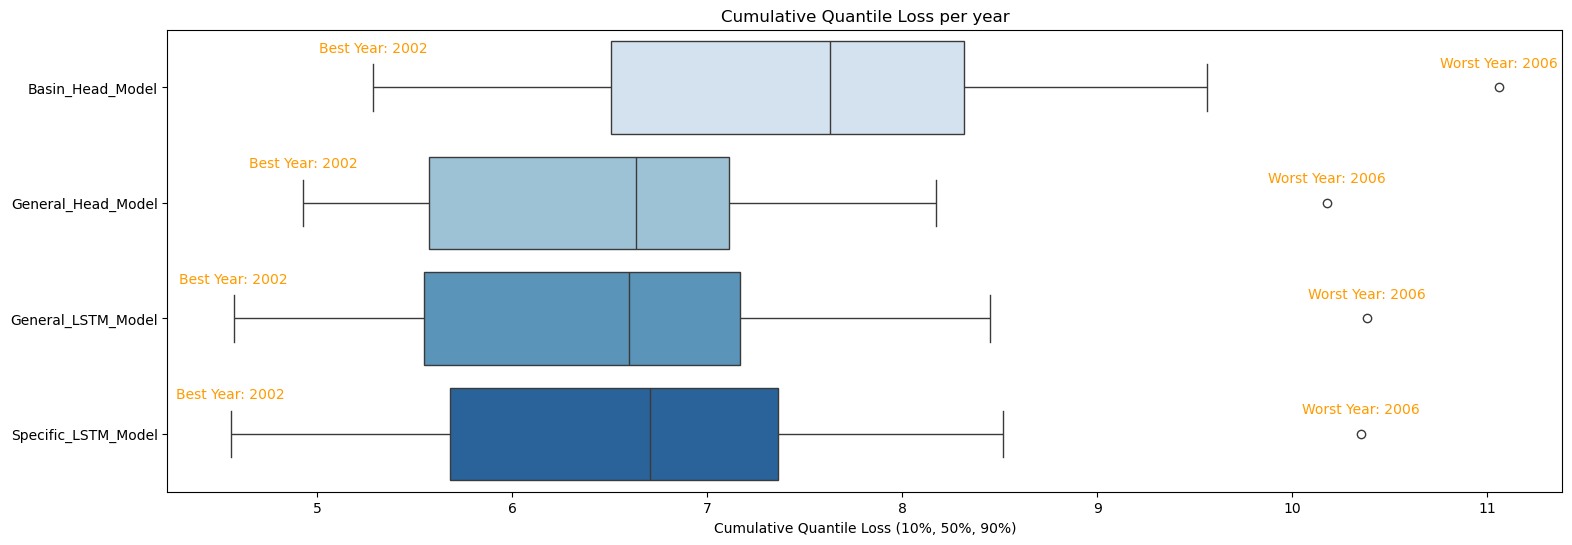

In [17]:
import seaborn as sns
sns.color_palette('colorblind')
df = years_df.drop(columns= 'Climatology_Model')
plt.figure(figsize=(18, 6))
sns.boxplot(data=df, orient = 'h', palette='Blues')


# Find the index of the best and worst points
best_indices = df.idxmin()
worst_indices = df.idxmax()

# Add text annotations to the plot for each column
for col in df.columns:
    best_index = best_indices[col]
    worst_index = worst_indices[col]
    
    best_point = df.loc[best_index, col]
    worst_point = df.loc[worst_index, col]
    
    plt.text(best_point , df.columns.get_loc(col) - 0.4, f'Best Year: {best_index}', ha='center', va='top', color='#ff9b00')
    plt.text(worst_point , df.columns.get_loc(col) - 0.15, f'Worst Year: {worst_index}', ha='center', va='bottom', color='#ff9b00')

plt.xlabel('Cumulative Quantile Loss (10%, 50%, 90%)')
plt.title('Cumulative Quantile Loss per year')
plt.show()

In [12]:
df.columns[1:]

Index(['General_Head_Model', 'General_LSTM_Model', 'Specific_LSTM_Model'], dtype='object')

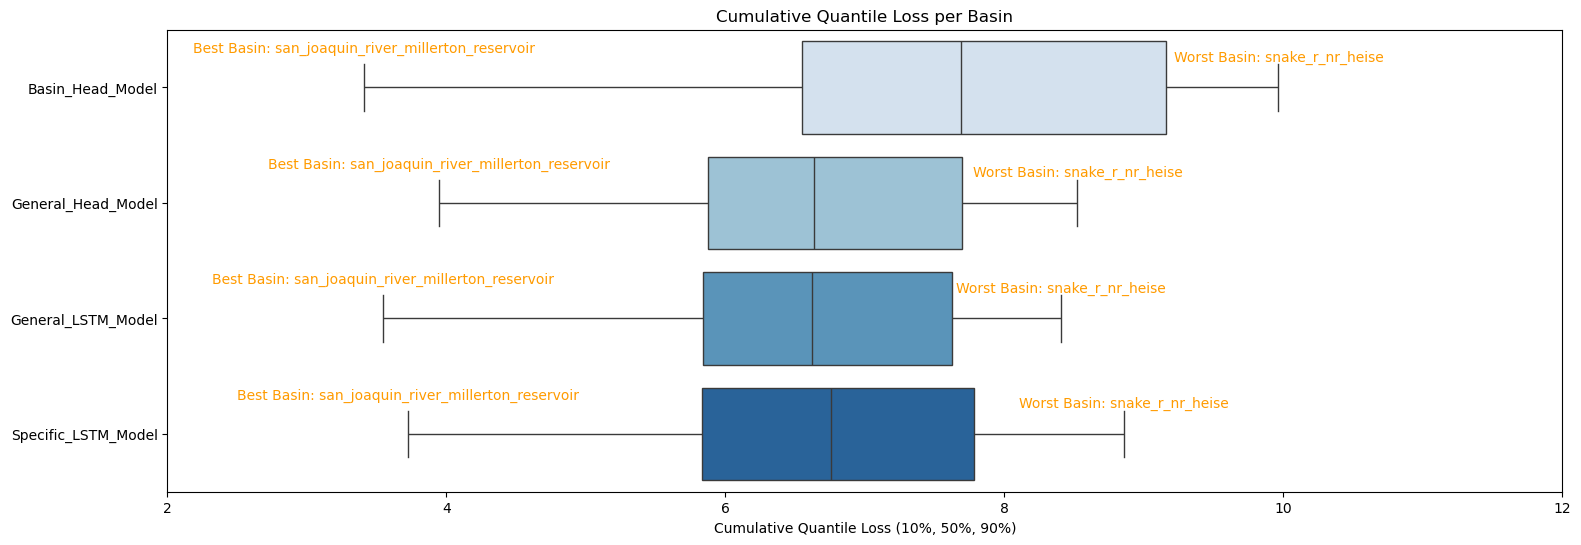

In [22]:
import seaborn as sns
df = basins_df.drop(columns= 'Climatology_Model')
plt.figure(figsize=(18, 6))
sns.boxplot(data=df, orient = 'h', palette='Blues')


# Find the index of the best and worst points
best_indices = df.idxmin()
worst_indices = df.idxmax()

# Add text annotations to the plot for each column
for col in df.columns:
    best_index = best_indices[col]
    worst_index = worst_indices[col]
    
    best_point = df.loc[best_index, col]
    worst_point = df.loc[worst_index, col]
    
    plt.text(best_point , df.columns.get_loc(col) - 0.4, f'Best Basin: {best_index}', ha='center', va='top', color='#ff9b00')
    plt.text(worst_point , df.columns.get_loc(col) - 0.2, f'Worst Basin: {worst_index}', ha='center', va='bottom', color='#ff9b00')

plt.xlim([2,12])
plt.xlabel('Cumulative Quantile Loss (10%, 50%, 90%)')


plt.title('Cumulative Quantile Loss per Basin')
plt.show()

In [18]:
basins_df[basins_df.index == 'libby_reservoir_inflow' ]

,Climatology_Model,Basin_Head_Model,General_Head_Model,General_LSTM_Model,Specific_LSTM_Model
libby_reservoir_inflow,8.684896,9.378435,8.403527,8.119832,8.294888


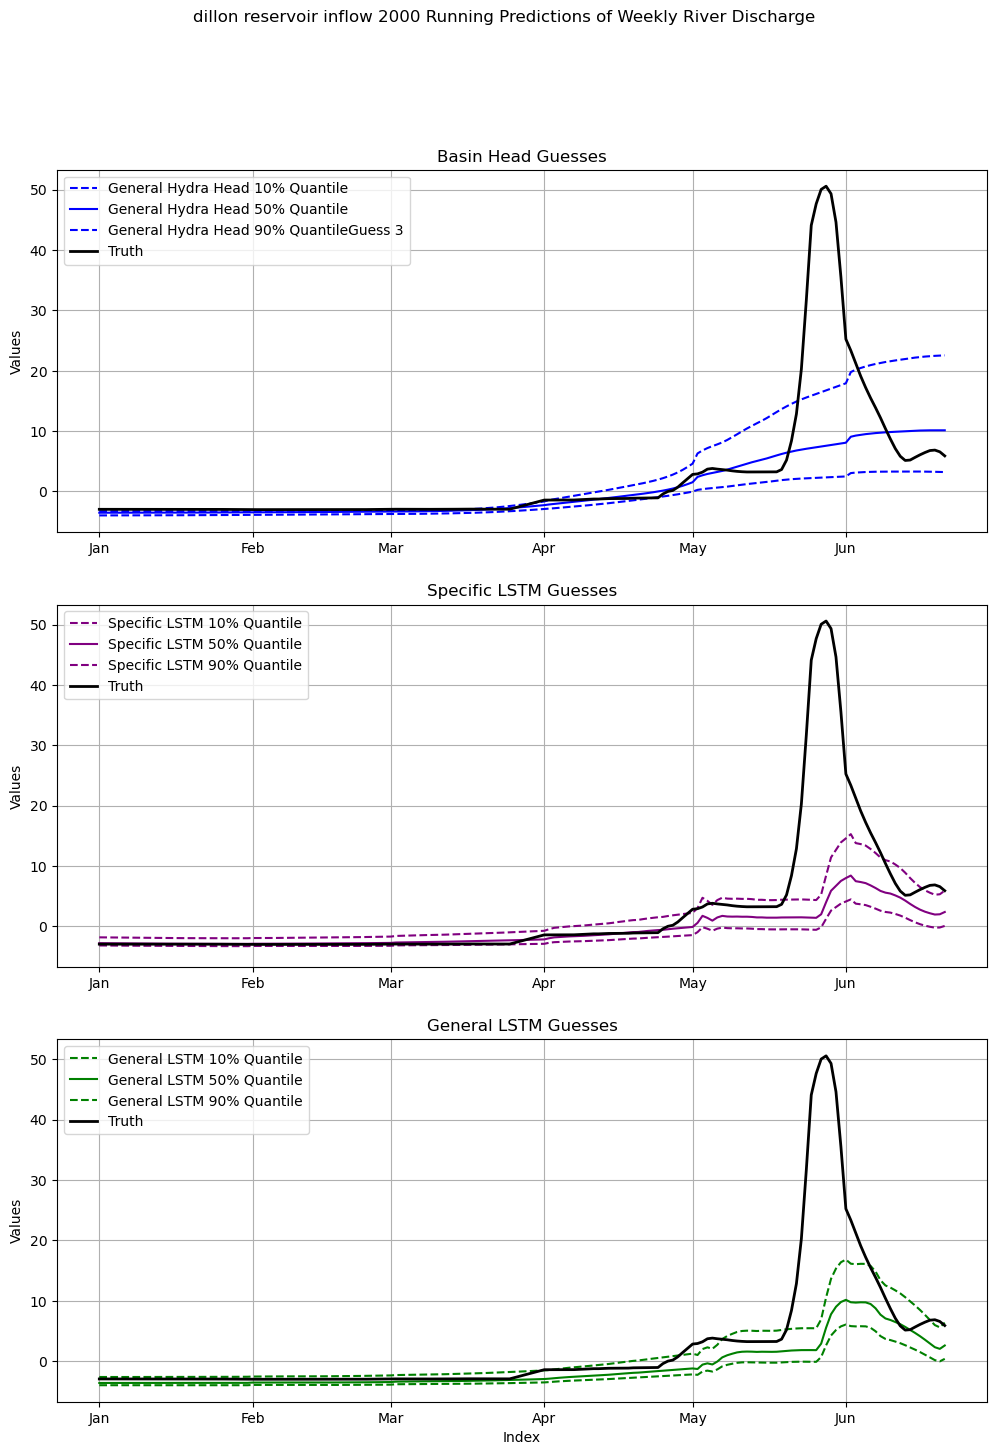

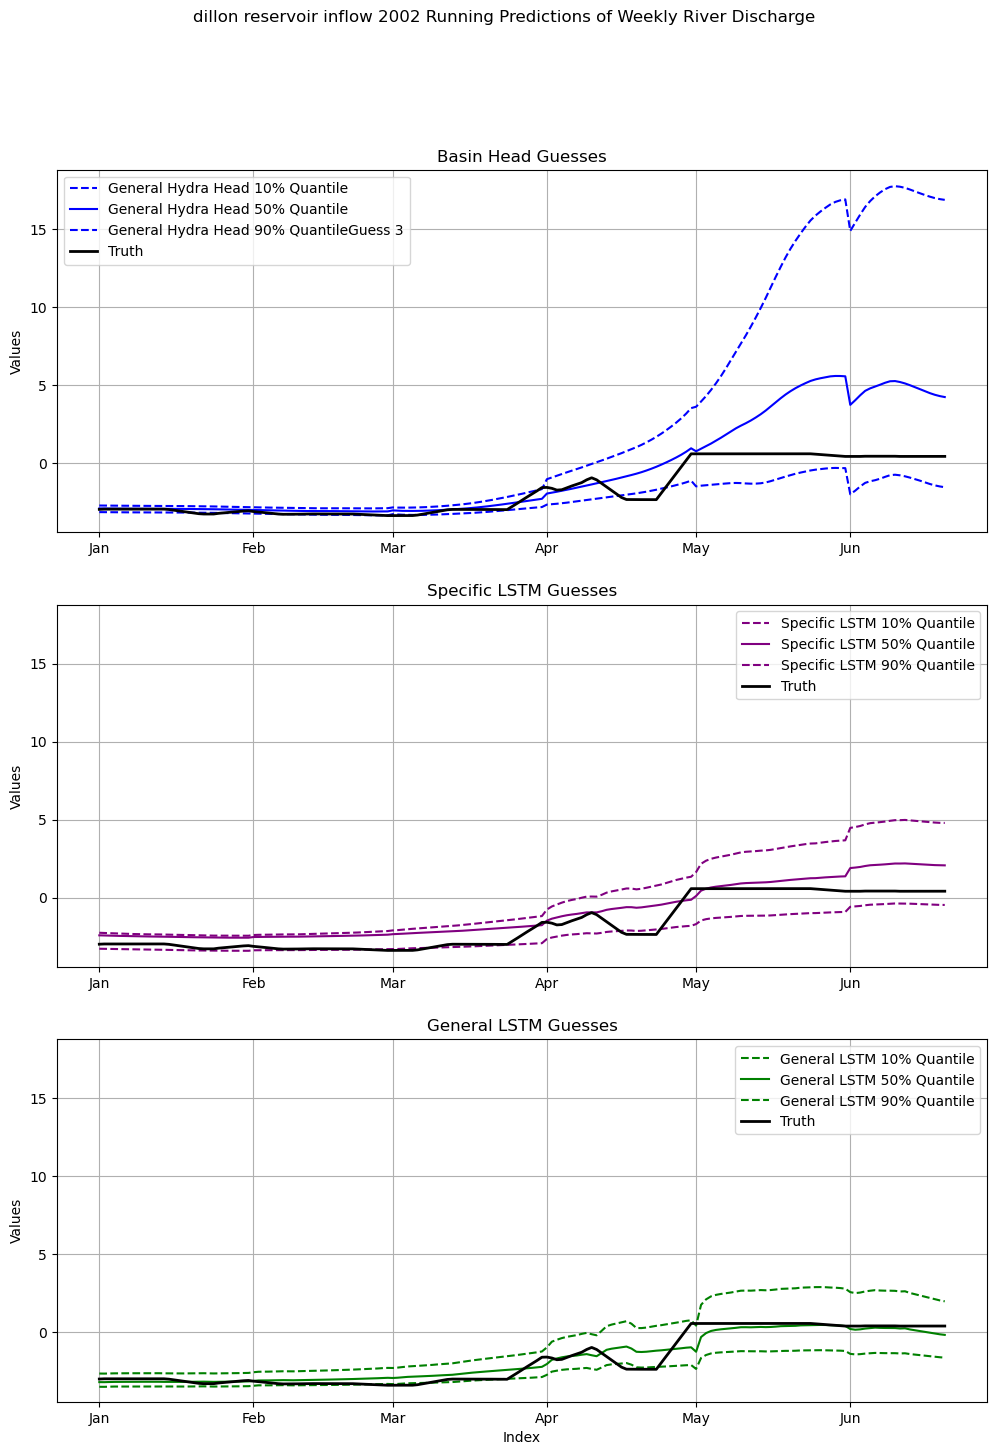

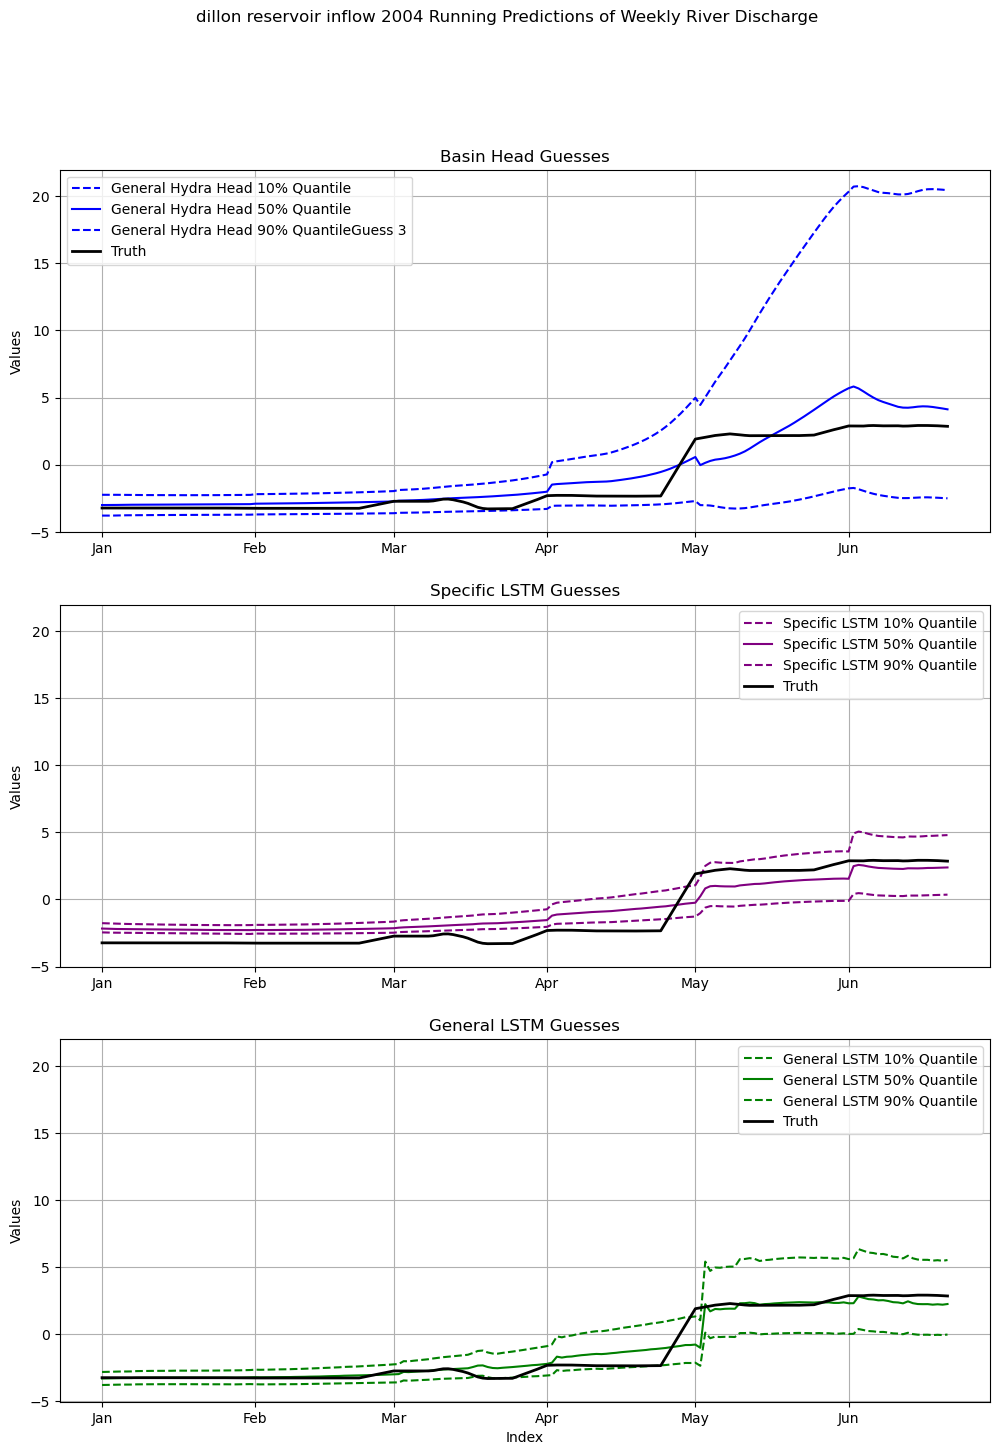

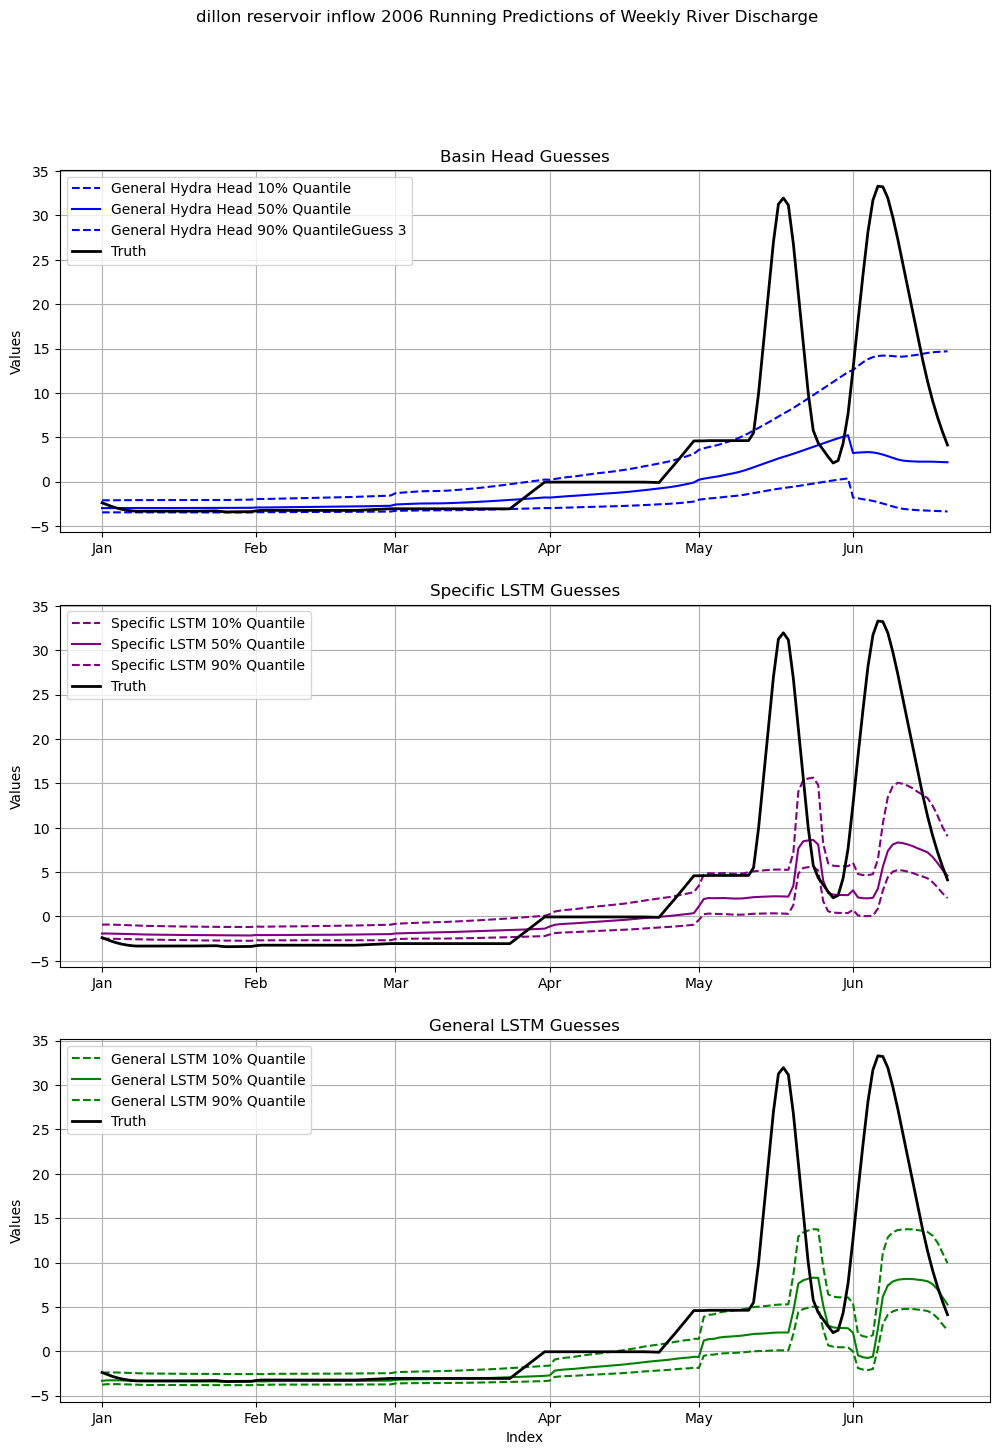

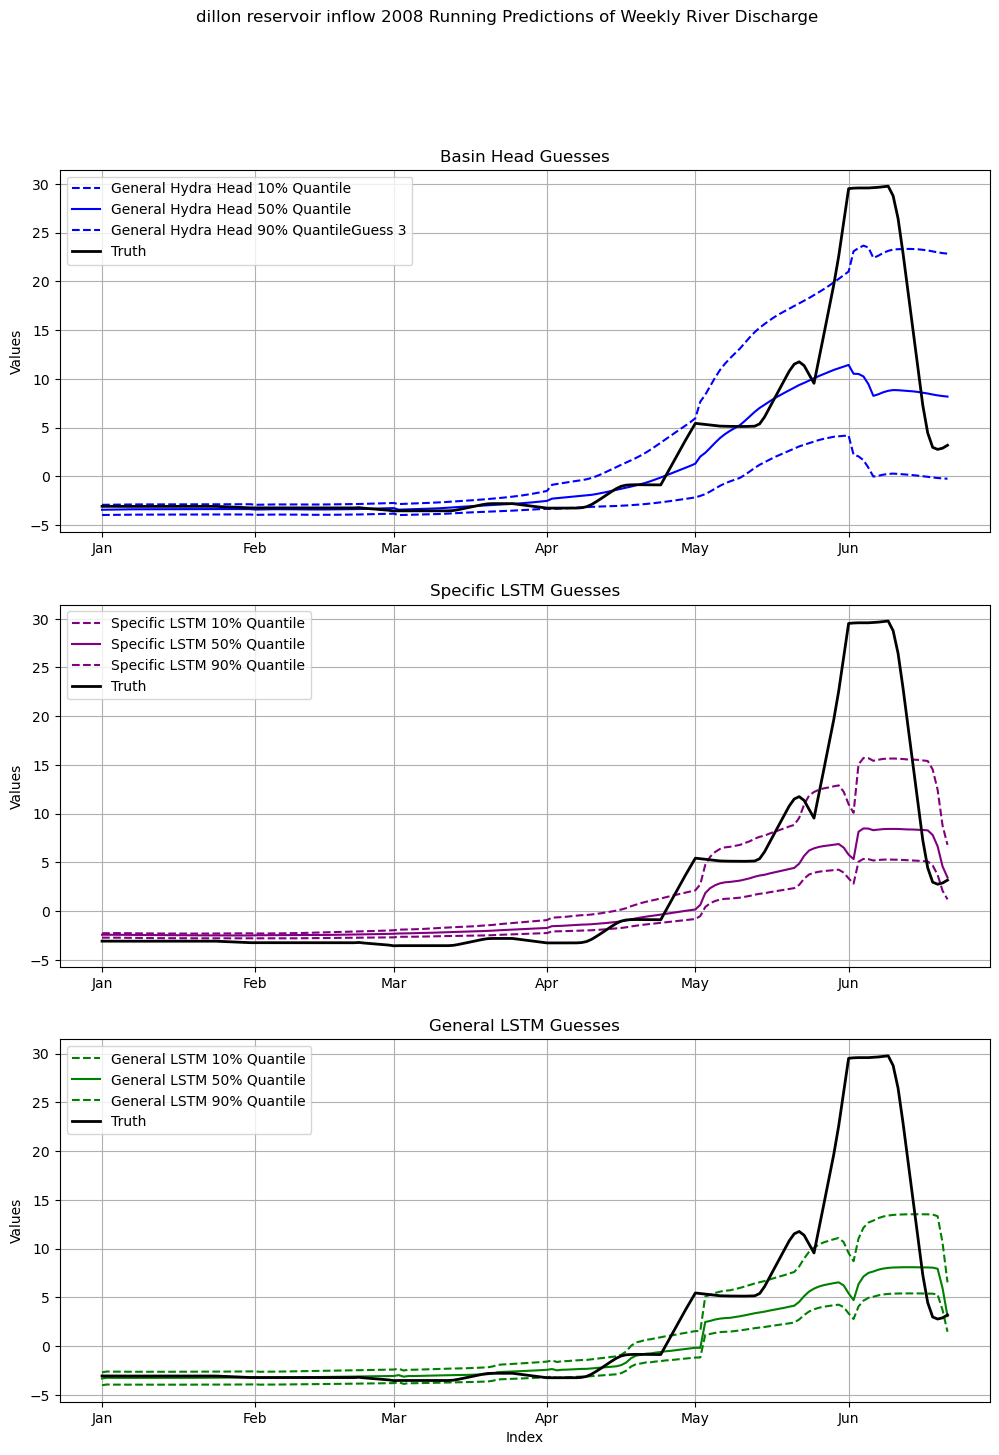

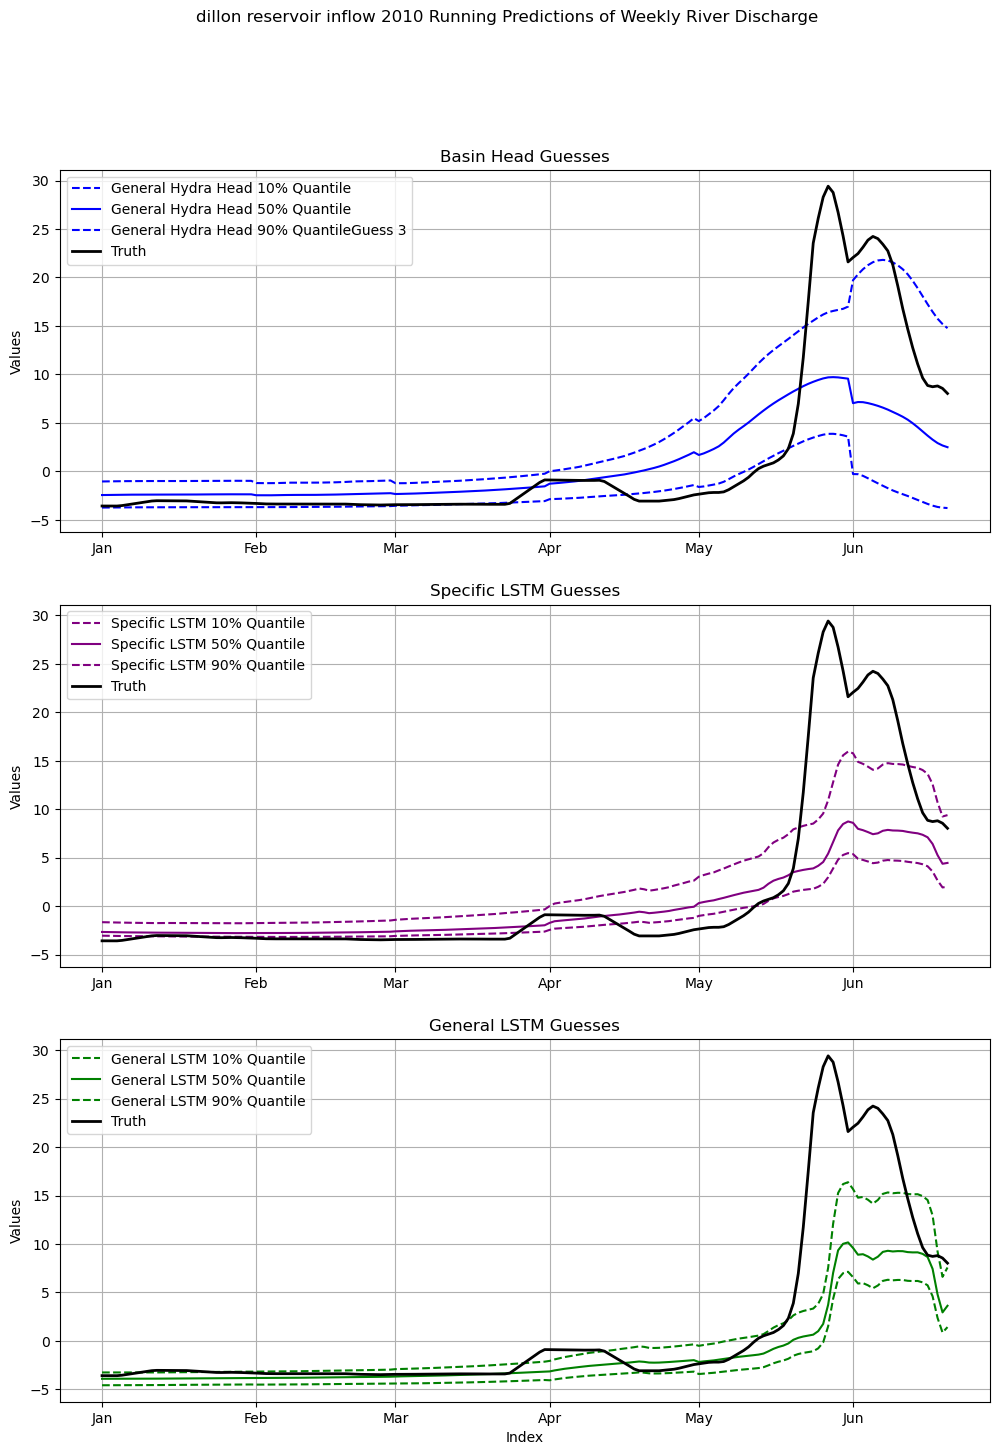

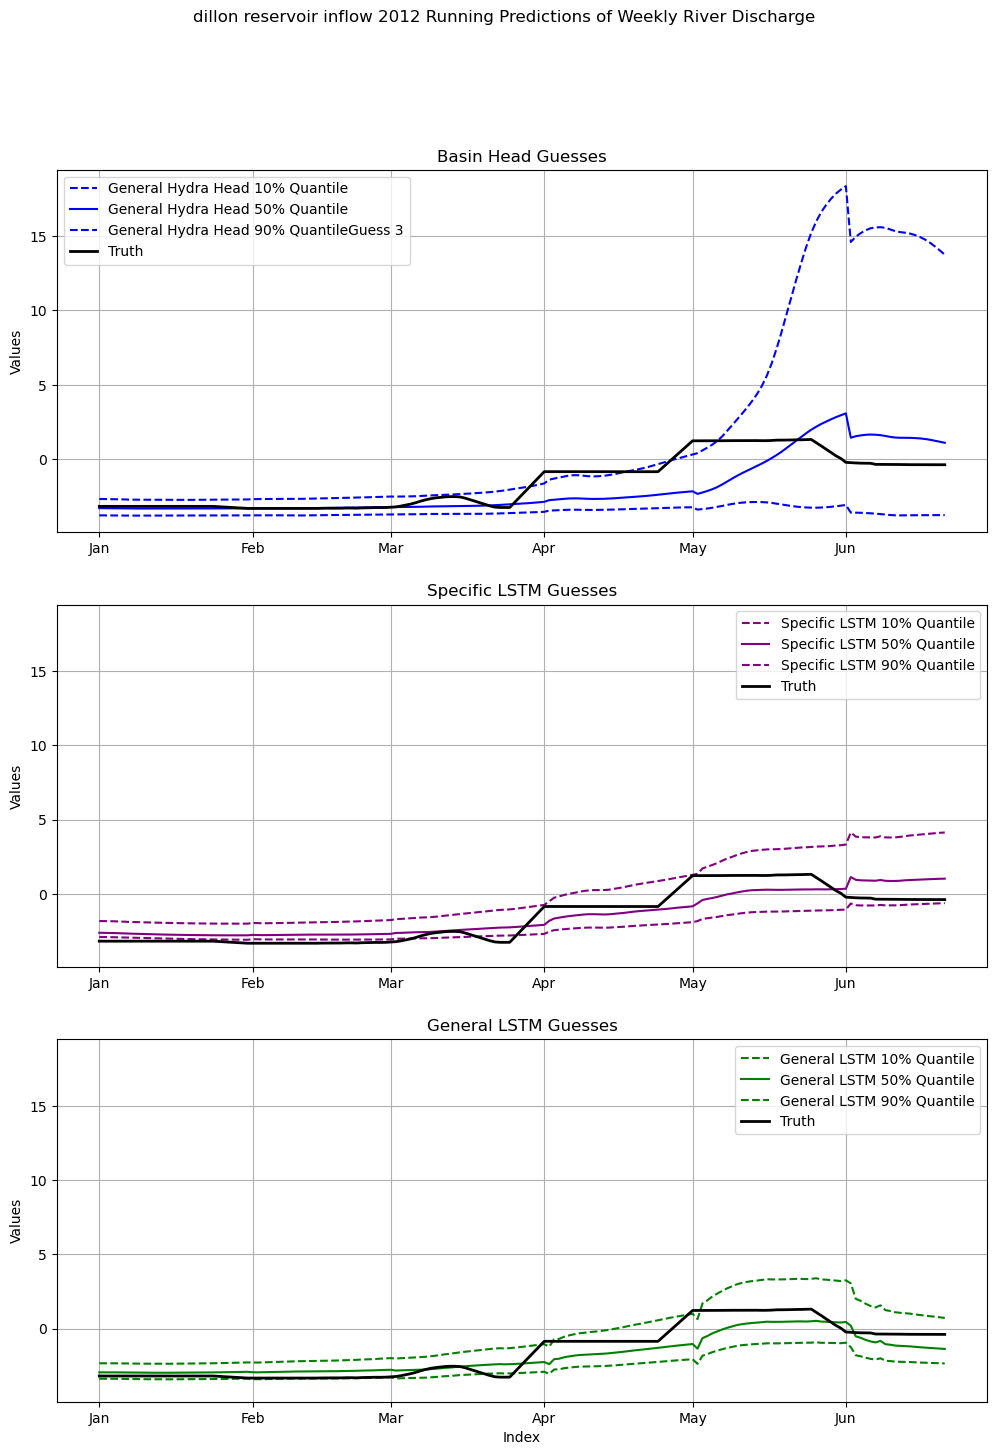

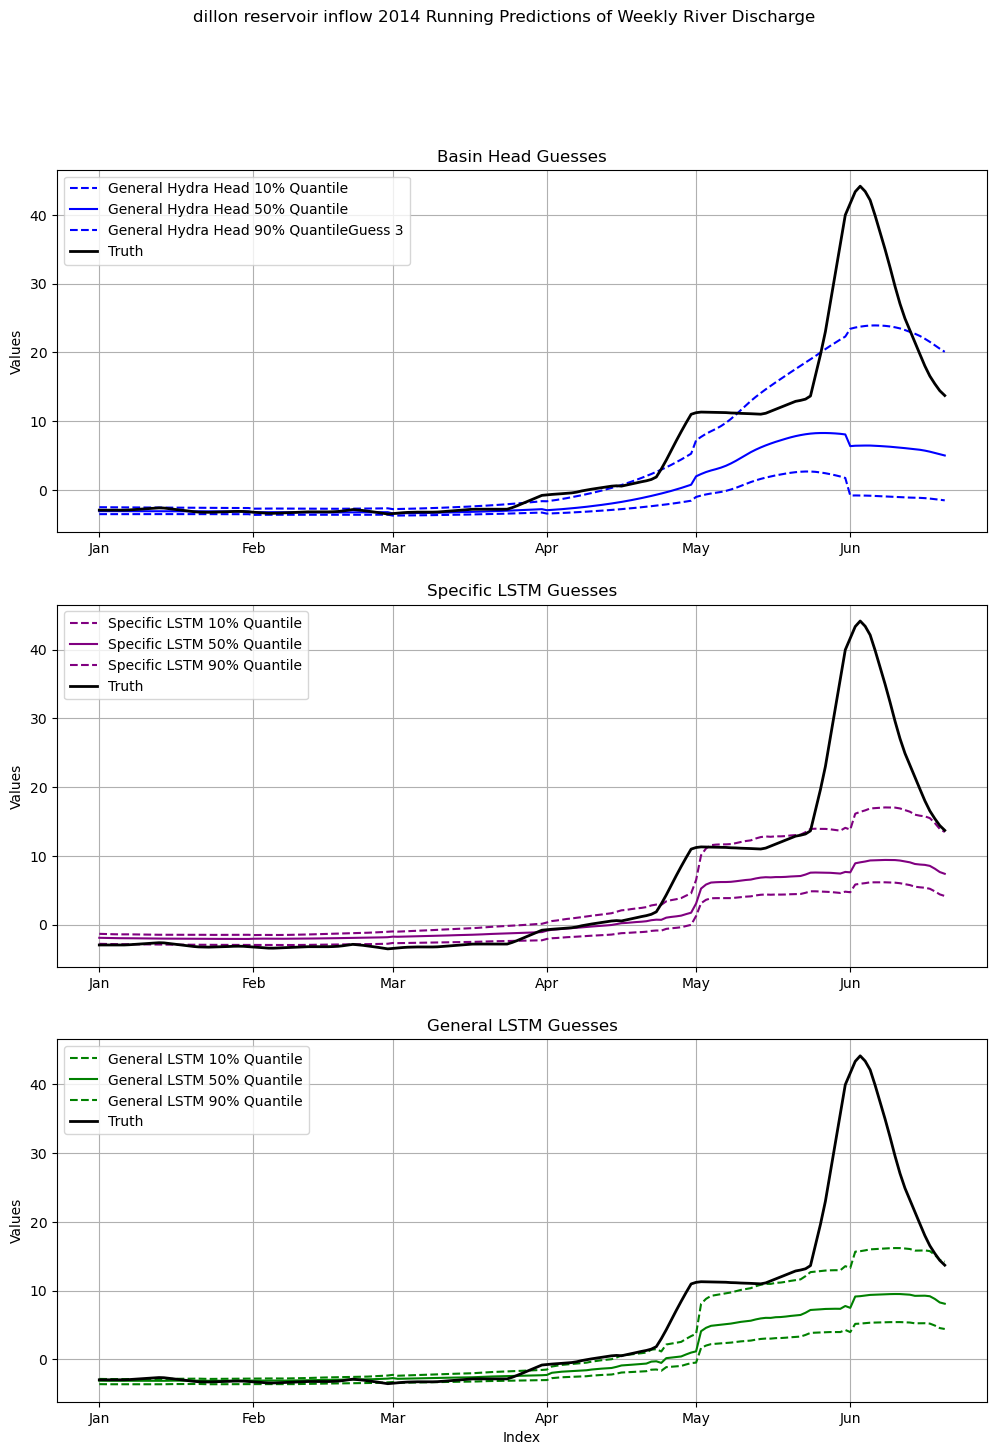

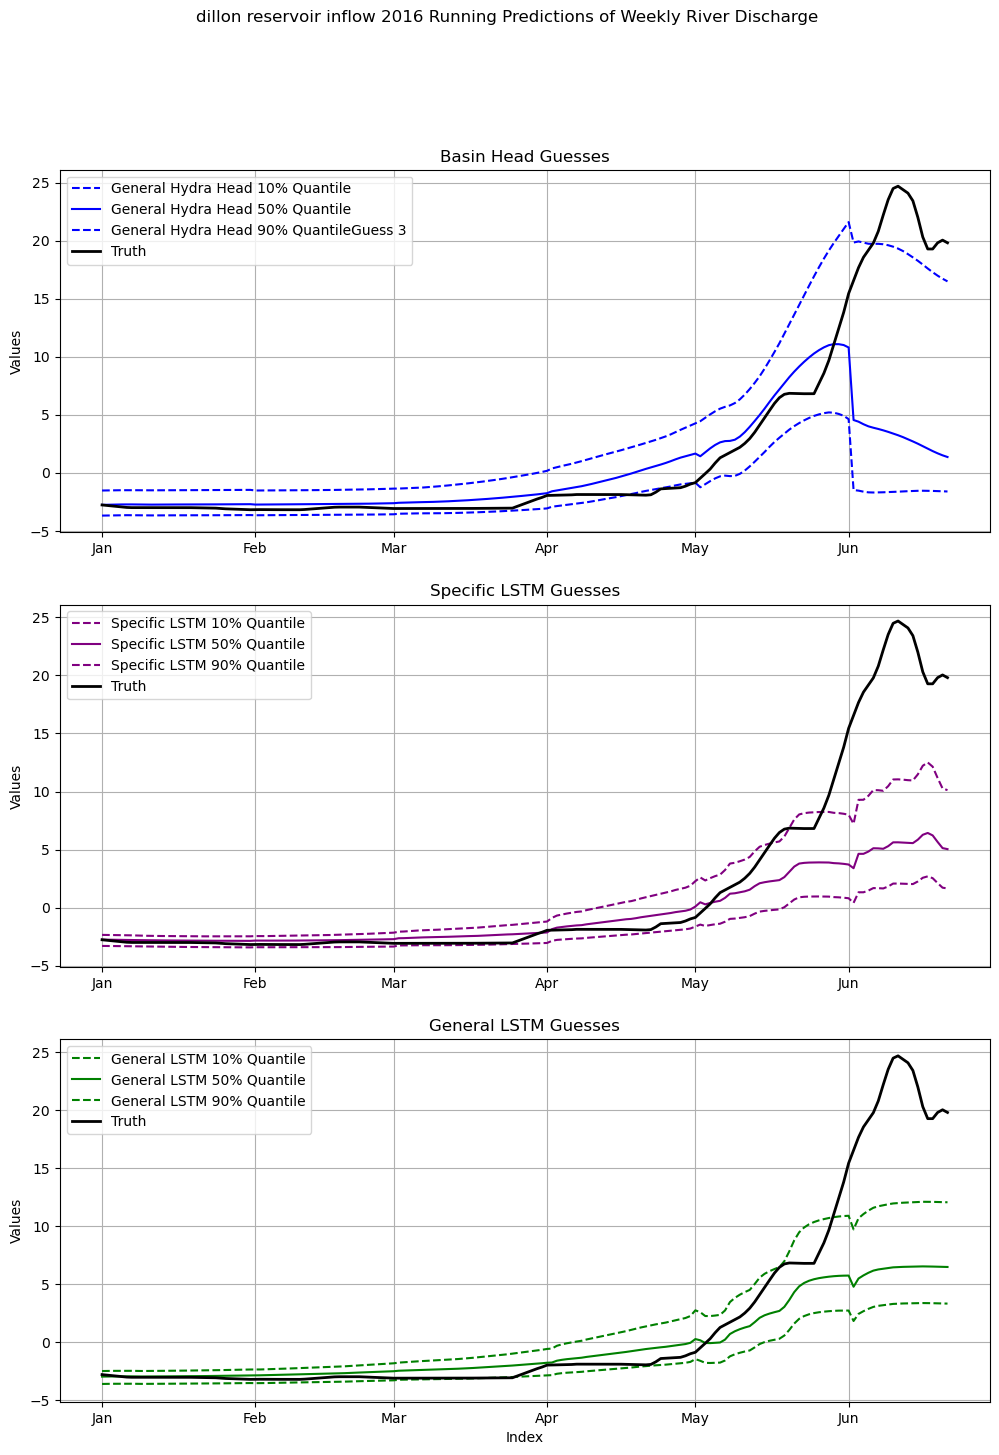

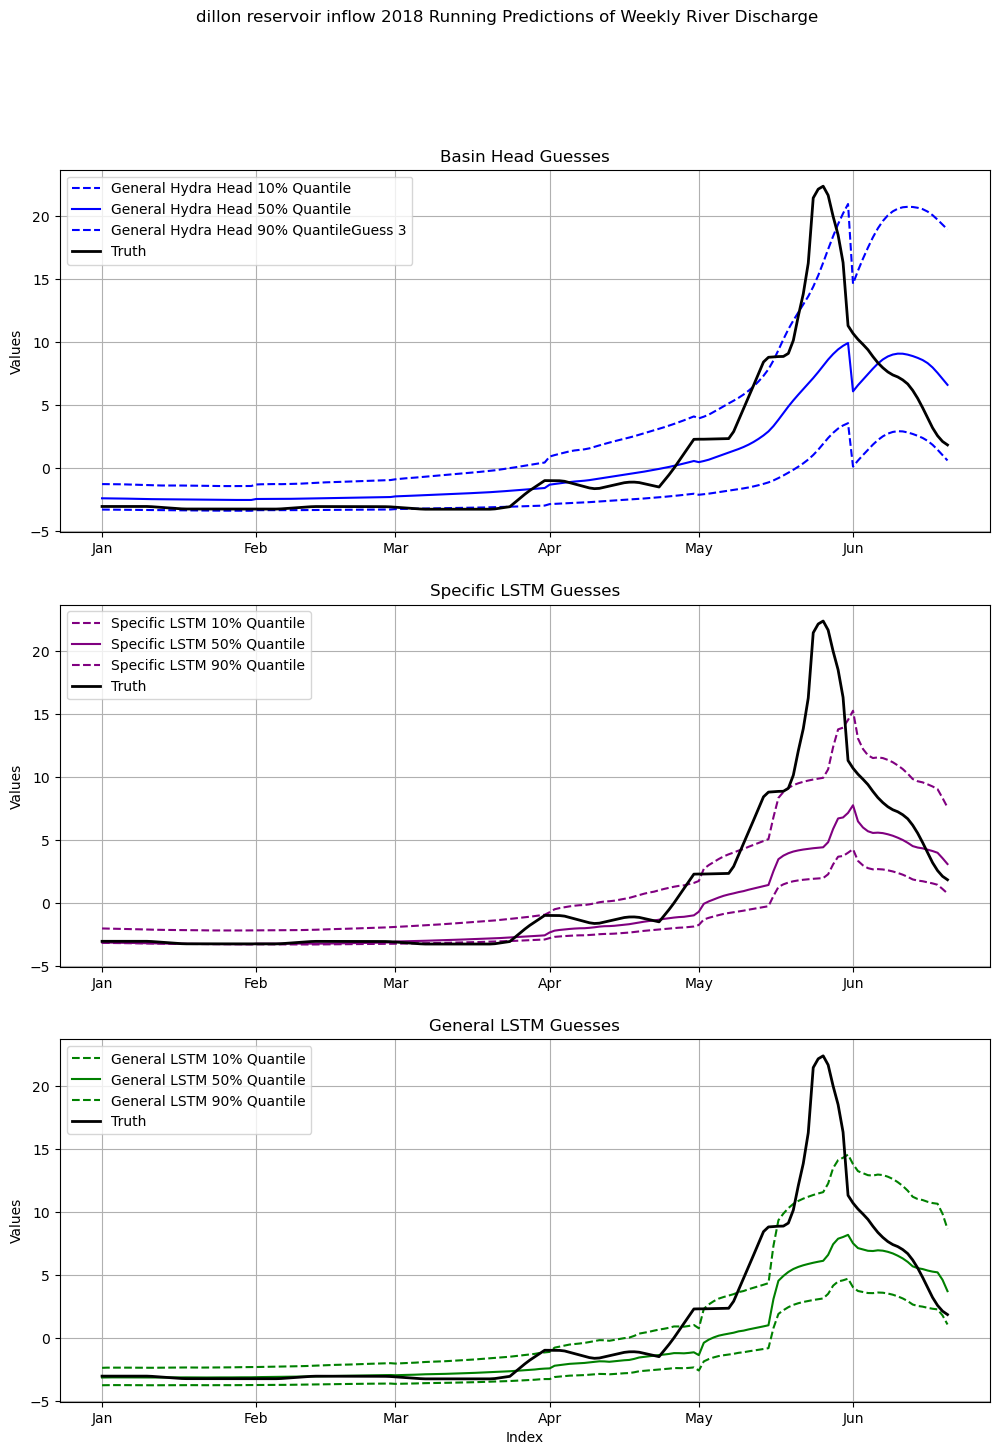

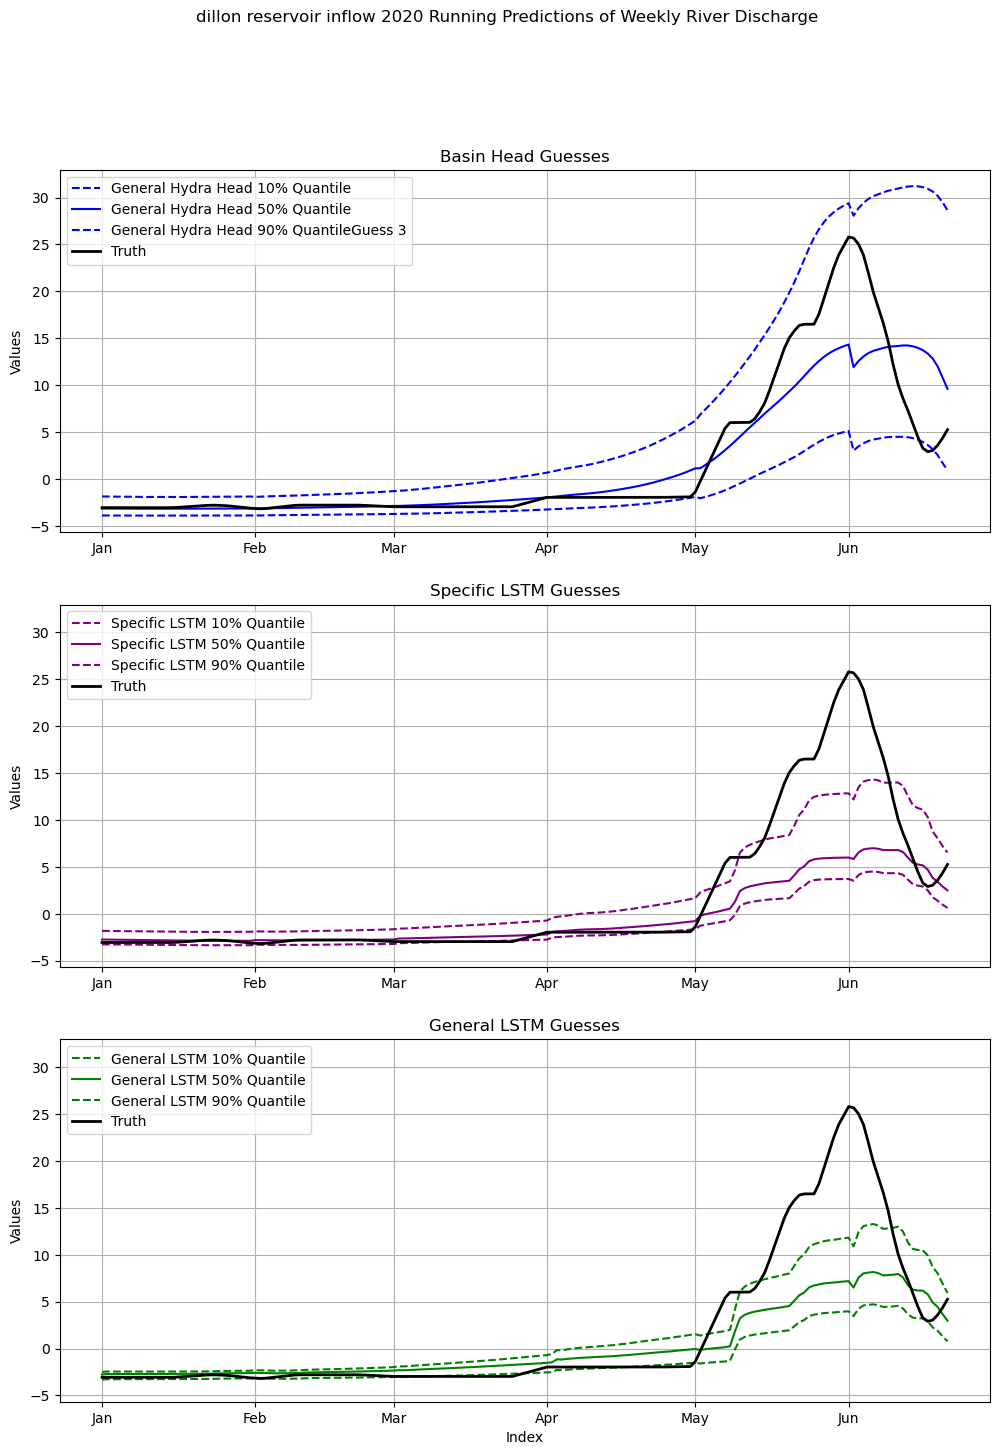

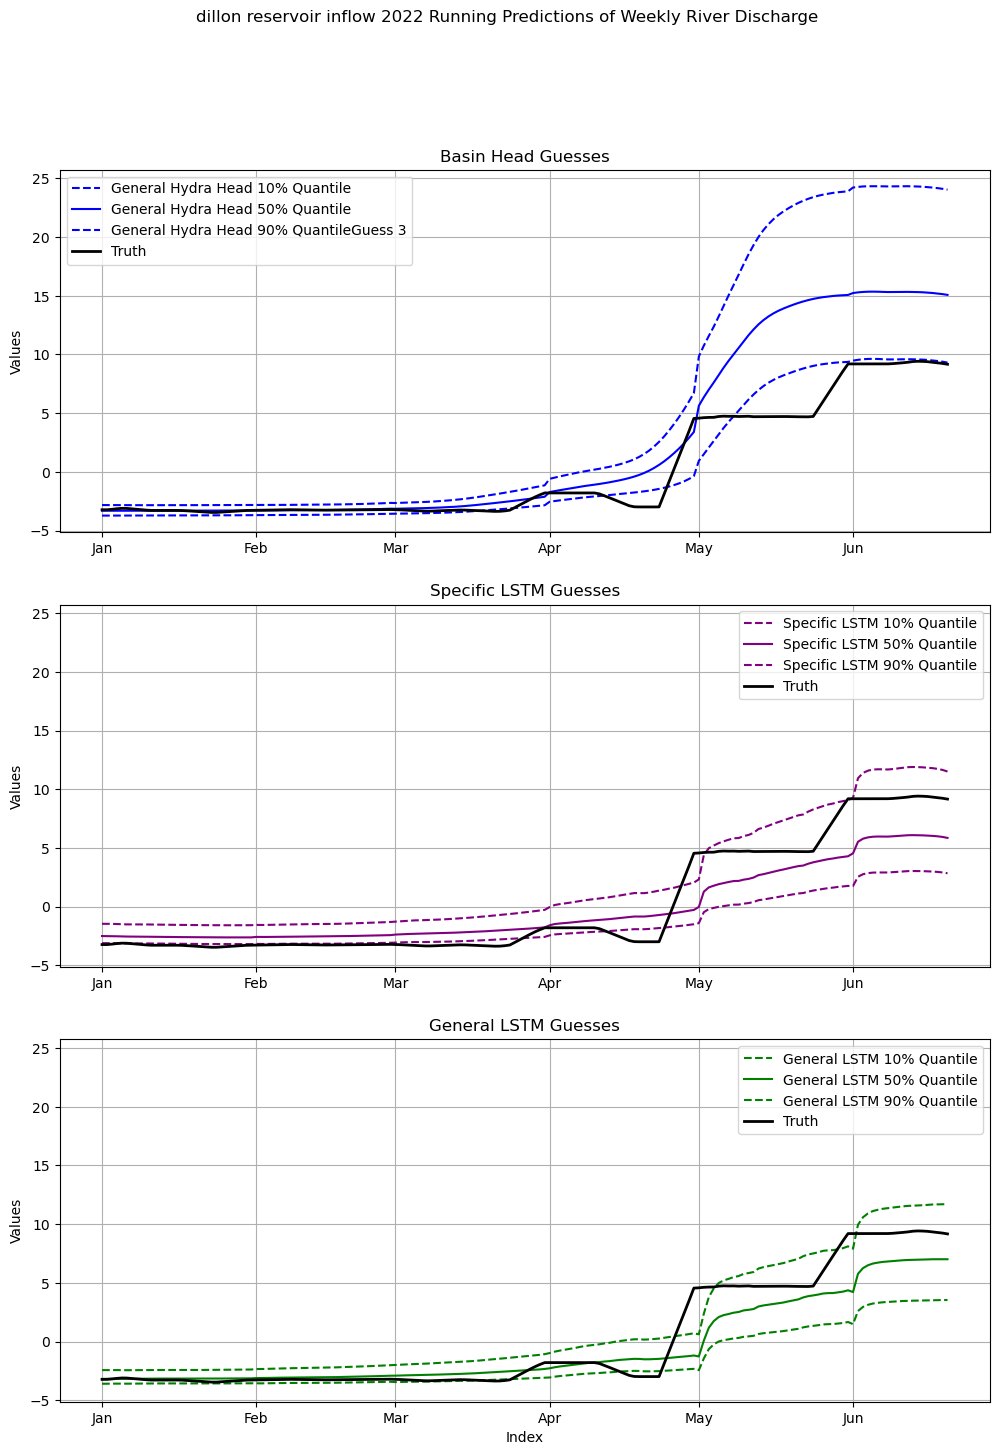

In [54]:
years = np.arange(2000,2024,2)

for year in years :
    start_season_date = f'{year}-01-01' 
    end_season_date = f'{year}-06-26'
    basin = 'dillon_reservoir_inflow'
            
    General_LSTM_Model = torch.load(f'/data/Hydra_Work/Validation_Models/{year}/General_LSTM_Model/General_LSTM.pth')
    Hydra_General_Head = torch.load(f'/data/Hydra_Work/Validation_Models/{year}/General_Head_Model/Hydra_Head_LSTM.pth')
    Hydra_Body = torch.load(f'/data/Hydra_Work/Validation_Models/{year}/General_Head_Model/Hydra_Body_LSTM.pth')
    Specific_Heads = {}
    Specific_Models = {}
    Specific_Heads[f'{basin}'] = torch.load(f'/data/Hydra_Work/Validation_Models/{year}/Basin_Head_Model/{basin}.path')
    Specific_Models[f'{basin}'] = torch.load(f'/data/Hydra_Work/Validation_Models/{year}/Specific_LSTM_Model/{basin}_specific.pth') 
            

    Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False)
    _, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = False)
    _, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = True)
    
    Days = len(Basin_Head_Guesses)
    Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
    General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
    Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

    General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
    Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)

    plot_predictions(General_Head_Guesses, Specific_LSTM_Guesses, General_LSTM_Guesses, Truth, f'{basin}', year, start_season_date, end_season_date)


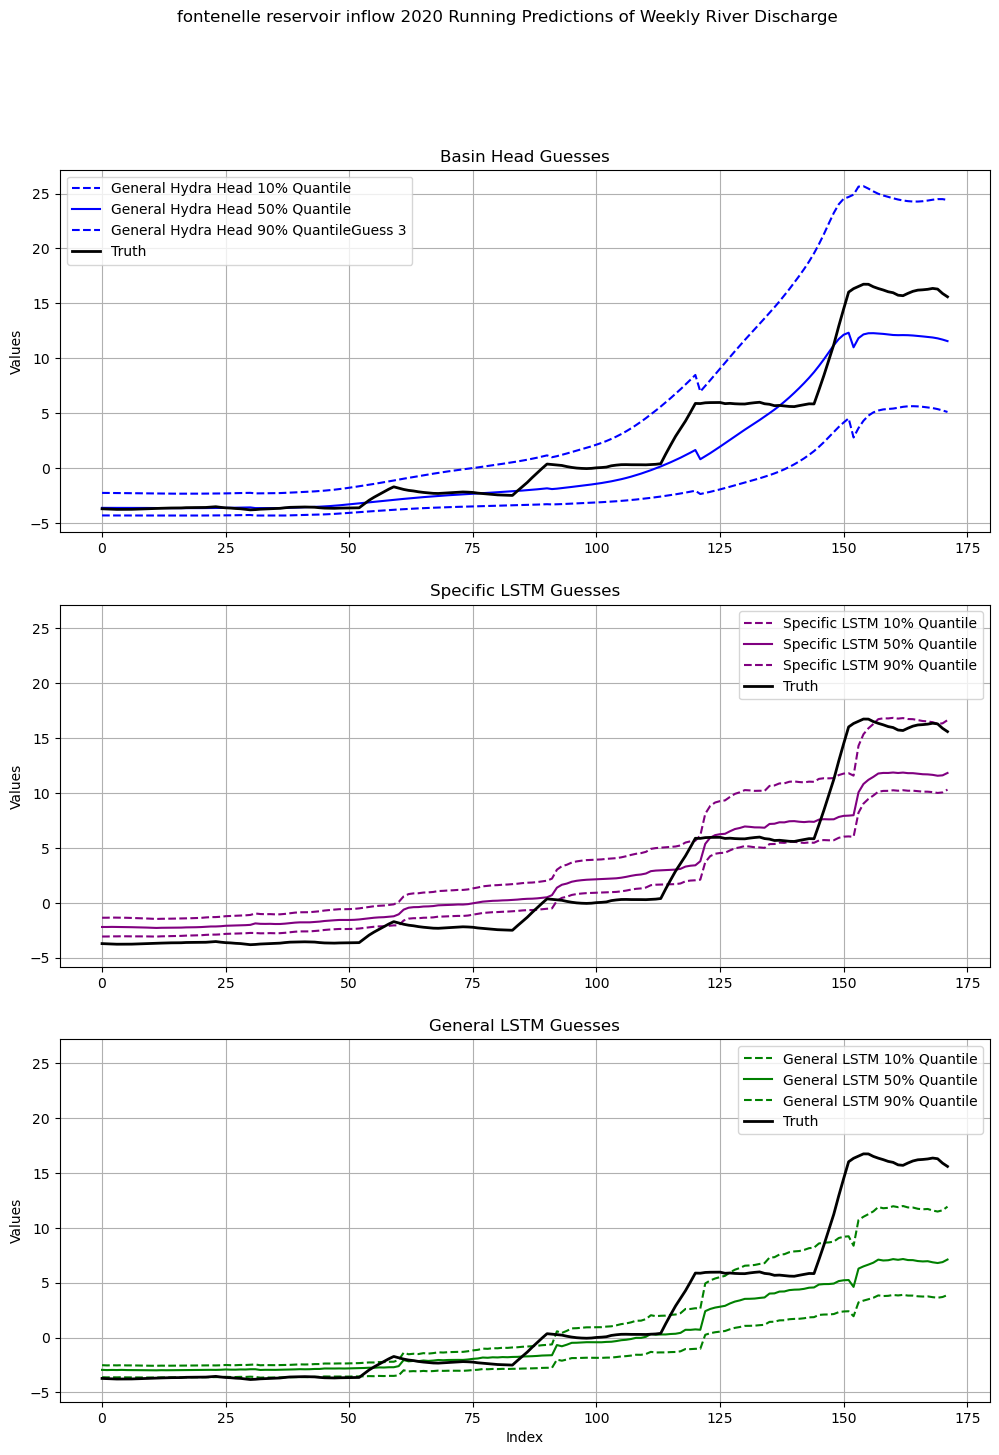

In [46]:
year = 2020
basin = 'fontenelle_reservoir_inflow'
#daily_flow['fontenelle_reservoir_inflow']

start_season_date = f'{year}-01-01' 
end_season_date = f'{year}-06-26'
        
General_LSTM_Model = torch.load(f'/data/Hydra_Work/Validation_Models/{year}/General_LSTM_Model/General_LSTM.pth')
Hydra_General_Head = torch.load(f'/data/Hydra_Work/Validation_Models/{year}/General_Head_Model/Hydra_Head_LSTM.pth')
Hydra_Body = torch.load(f'/data/Hydra_Work/Validation_Models/{year}/General_Head_Model/Hydra_Body_LSTM.pth')
Specific_Heads = {}
Specific_Models = {}
Specific_Heads[f'{basin}'] = torch.load(f'/data/Hydra_Work/Validation_Models/{year}/Basin_Head_Model/{basin}.path')
Specific_Models[f'{basin}'] = torch.load(f'/data/Hydra_Work/Validation_Models/{year}/Specific_LSTM_Model/{basin}_specific.pth') 
        

Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False)
_, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = False)
_, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = True)

Days = len(Basin_Head_Guesses)
Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)

plot_predictions(General_Head_Guesses, Specific_LSTM_Guesses, General_LSTM_Guesses, Truth, f'{basin}', year)


In [56]:
from datetime import datetime, timedelta
import matplotlib.dates as mdates

def plot_predictions(Basin_Head_Guesses, Specific_LSTM_Guesses, General_LSTM_Guesses, Truth, basin, year, start_date, end_date):
    fig, axs = plt.subplots(3, 1, figsize=(12, 16), sharex= False)

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Calculate the number of days and generate date range
    days = (end_date - start_date).days
    dates = [start_date + timedelta(days=i) for i in range(days)]

    # Plot Basin Head Guesses
    axs[0].plot(Basin_Head_Guesses[:, 0], color='blue', linestyle='--', label='General Hydra Head 10% Quantile')
    axs[0].plot(Basin_Head_Guesses[:, 1], color='blue', linestyle='-', label='General Hydra Head 50% Quantile')
    axs[0].plot(Basin_Head_Guesses[:, 2], color='blue', linestyle='--', label='General Hydra Head 90% QuantileGuess 3')
    axs[0].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
    axs[0].set_ylabel('Values')
    axs[0].set_title('Basin Head Guesses')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Specific Model Guesses
    axs[1].plot(Specific_LSTM_Guesses[:, 0], color='purple', linestyle='--', label='Specific LSTM 10% Quantile')
    axs[1].plot(Specific_LSTM_Guesses[:, 1], color='purple', linestyle='-', label='Specific LSTM 50% Quantile')
    axs[1].plot(Specific_LSTM_Guesses[:, 2], color='purple', linestyle='--', label='Specific LSTM 90% Quantile')
    axs[1].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
    axs[1].set_ylabel('Values')
    axs[1].set_title('Specific LSTM Guesses')
    axs[1].legend()
    axs[1].grid(True)

    # Plot General LSTM Guesses
    axs[2].plot(General_LSTM_Guesses[:, 0], color='green', linestyle='--', label='General LSTM 10% Quantile')
    axs[2].plot(General_LSTM_Guesses[:, 1], color='green', linestyle='-', label='General LSTM 50% Quantile')
    axs[2].plot(General_LSTM_Guesses[:, 2], color='green', linestyle='--', label='General LSTM 90% Quantile')
    axs[2].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
    axs[2].set_ylabel('Values')
    axs[2].set_title('General LSTM Guesses')
    axs[2].set_xlabel('Index')
    axs[2].legend()
    axs[2].grid(True)

    # Set the same y-limits for all subplots
    y_limits = [
        axs[0].get_ylim(),
        axs[1].get_ylim(),
        axs[2].get_ylim(),
    ]

    common_y_limits = (min([lim[0] for lim in y_limits]), max([lim[1] for lim in y_limits]))

    for ax in axs:
        ax.set_ylim(common_y_limits)
        # Format the x-axis to show months
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


    formatted_basin = basin.replace('_', ' ')
    # Customize the plot
    plt.suptitle(f'{formatted_basin} {year} Running Predictions of Weekly River Discharge ')


    # Show the plot
    plt.show()

# Example usage (assuming you have the data arrays):


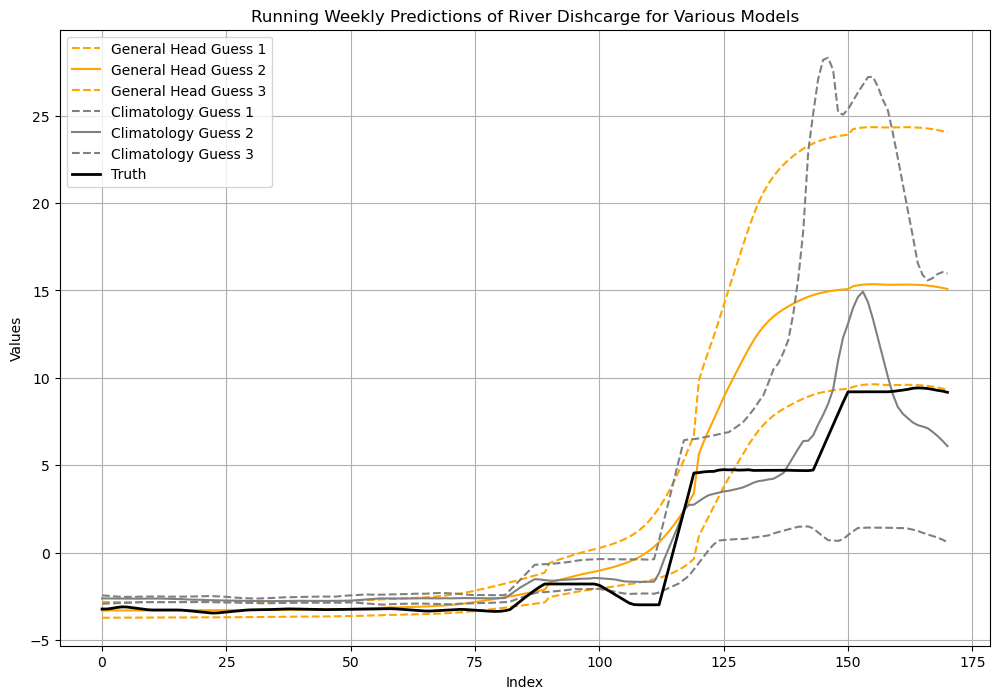

In [55]:
# Plot the data
plt.figure(figsize=(12, 8))

# Plot Basin Head Guesses
# plt.plot(Basin_Head_Guesses[:, 0], color='blue', linestyle='--', label='Basin Head Guess 1')
# plt.plot(Basin_Head_Guesses[:, 1], color='blue', linestyle='-', label='Basin Head Guess 2')
# plt.plot(Basin_Head_Guesses[:, 2], color='blue', linestyle='--', label='Basin Head Guess 3')

# # Plot General Head Guesses
plt.plot(General_Head_Guesses[:, 0], color='orange', linestyle='--', label='General Head Guess 1')
plt.plot(General_Head_Guesses[:, 1], color='orange', linestyle='-', label='General Head Guess 2')

plt.plot(General_Head_Guesses[:, 2], color='orange', linestyle='--', label='General Head Guess 3')

# # Plot General Guesses
# plt.plot(General_LSTM_Guesses[:, 0], color='cyan', linestyle='--', label='General LSTM Guess 1')
# plt.plot(General_LSTM_Guesses[:, 1], color='cyan', linestyle='-', label='General LSTM Guess 2')
# plt.plot(General_LSTM_Guesses[:, 2], color='cyan', linestyle='--', label='General LSTM Guess 3')

# Plot Specific Model Guesses
# plt.plot(Specific_LSTM_Guesses[:, 0], color='purple', linestyle='--', label='Specific LSTM Guess 1')
# plt.plot(Specific_LSTM_Guesses[:, 1], color='purple', linestyle='-', label='Specific LSTM Guess 2')
# plt.plot(Specific_LSTM_Guesses[:, 2], color='purple', linestyle='--', label='Specific LSTM Guess 3')


#Plot Climatology Guesses
plt.plot(Climatology_Guesses[:, 0], color='grey', linestyle='--', label='Climatology Guess 1')
plt.plot(Climatology_Guesses[:, 1], color='grey', linestyle='-', label='Climatology Guess 2')
plt.plot(Climatology_Guesses[:, 2], color='grey', linestyle='--', label='Climatology Guess 3')


# Plot Truth
plt.plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')

    # Customize the plot
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Running Weekly Predictions of River Dishcarge for Various Models')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()